<a href="https://colab.research.google.com/github/Sibgat-Ul/CodeFromPaper/blob/main/AlexNet/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [70]:
transform = transforms.Compose(
  [
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
  ]
)

batch_size = 4

In [71]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [72]:
test_set = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


torch.Size([4, 3, 32, 32])
(3, 36, 138) (36, 138, 3)


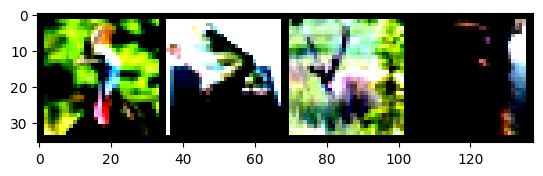

bird  frog  deer  dog  


In [92]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    normalized = img
    npimg0 = normalized.numpy()
    transposed = np.transpose(npimg0, (1, 2, 0))
    print(npimg0.shape, transposed.shape)
    plt.imshow(transposed)
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Step by step convultion and outputs

#### Original image

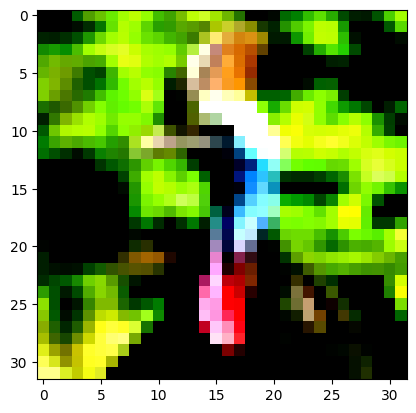

In [93]:
plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

#### After convolution

(6, 6) torch.Size([6, 27, 27])
(3, 31, 176) (31, 176, 3)


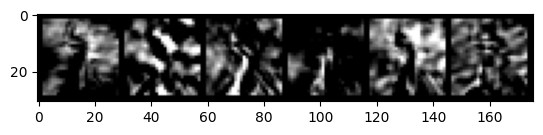

In [94]:
conv_test = nn.Conv2d(3, 6, 6)
conv_test_out = conv_test(images[0])
print(conv_test.kernel_size, conv_test_out.shape)
# conv_test_out
imshow(torchvision.utils.make_grid(conv_test_out.unsqueeze(1).detach()))

#### After applying relu



torch.Size([6, 27, 27])
(3, 31, 176) (31, 176, 3)


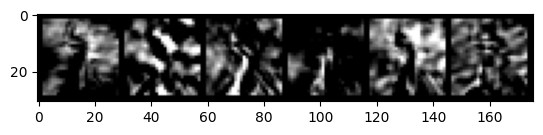

In [95]:
relu_test = nn.ReLU()
relu_test_out = relu_test(conv_test_out)
print(relu_test_out.shape)
imshow(torchvision.utils.make_grid(relu_test_out.unsqueeze(1).detach()))

#### Padding

torch.Size([6, 31, 31])
(3, 35, 200) (35, 200, 3)


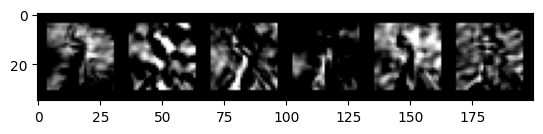

In [96]:
pad_test = nn.ZeroPad2d(2)
pad_test_out = pad_test(relu_test_out)
print(pad_test_out.shape)
imshow(torchvision.utils.make_grid(pad_test_out.unsqueeze(1).detach()))

#### Max pooling

torch.Size([6, 10, 10])
(3, 14, 74) (14, 74, 3)


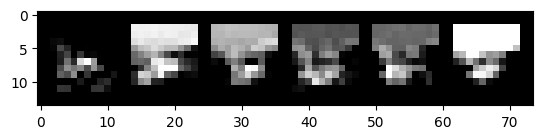

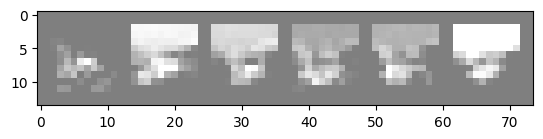

In [78]:
pool_test = nn.MaxPool2d(3, 3)
pool_test_out = pool_test(pad_test_out)
print(pool_test_out.shape)
imshow(torchvision.utils.make_grid(pool_test_out.unsqueeze(1).detach()))

### ImageNet with Deep CNN


In [88]:
import torch.nn.functional as F
from typing import Callable, List, Optional, Tuple, Union
import math
import warnings
import importlib
from torch import Tensor
from torch.nn import AvgPool2d, AvgPool3d, MaxPool2d, MaxPool3d

In [121]:
random_image = torch.randn((3, 227, 227))
random_image.shape

torch.Size([3, 227, 227])

In [122]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.resp_norm_l1 = nn.LocalResponseNorm(size=96,k=2)
        self.resp_norm_l2 = nn.LocalResponseNorm(size=256,k=2)
        self.pool = nn.MaxPool2d(stride=2, kernel_size=3)
        self.dropout = nn.Dropout()
        self.flatten = nn.Flatten(start_dim=0, end_dim=-1)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3)

        self.fc1 = nn.Linear(9216, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)

    def forward(self, x):
        first_layer_conv = self.conv1(x)
        first_layer_relu = self.relu(first_layer_conv)
        first_layer_norm = self.resp_norm_l1(first_layer_relu)
        # before pool: 55*55*96
        first_layer_pool = self.pool(first_layer_norm)
        # after pool: 27*27*96

        second_layer_conv = self.conv2(first_layer_pool)
        second_layer_relu = self.relu(second_layer_conv)
        second_layer_norm = self.resp_norm_l2(second_layer_relu)
        # 23*23*256
        second_layer_out = F.pad(input=second_layer_norm, pad=(2, 2, 2, 2), mode='constant', value=0)
        # 25*25*256
        second_layer_out = self.pool(second_layer_out)
        # 13*13*256


        third_layer_conv = self.conv3(second_layer_out)
        third_layer_relu = self.relu(third_layer_conv)
        # 11*11*384
        third_layer_out = F.pad(input=third_layer_relu, pad=(1, 1, 1, 1), mode='constant', value=0)
        # 13*13*384

        fourth_conv = self.conv4(third_layer_out)
        fourth_relu = self.relu(fourth_conv)
        # 11*11*384
        fourth_layer_out = F.pad(input=fourth_relu, pad=(1, 1, 1, 1), mode='constant', value=0)
        # 13*13*384

        fifth_conv = self.conv5(fourth_layer_out)
        fifth_relu = self.relu(fifth_conv)
        # 11*11*256
        fifth_layer_pad = F.pad(input=fifth_relu, pad=(2, 2, 2, 2), mode='constant', value=0)
        # 13*13*256
        fifth_layer_out = self.pool(fifth_layer_pad)
        # 6*6*256

        flattened = self.flatten(fifth_layer_out)
        # 1*9216
        fc1_out = self.fc1(flattened)
        fc1_out = self.relu(fc1_out)
        # 4096
        dropout = self.dropout(fc1_out)

        fc2_out = self.fc2(fc1_out)
        fc2_out = self.relu(fc2_out)
        # 4096
        dropout = self.dropout(fc2_out)

        fc3_out = self.fc3(fc2_out)
        # 1000

        return x


net = Net()

total_params = 0

for i, params in enumerate(net.parameters()):
  total_params += params.numel()
  index = (i // 2) + 1

  if i%2 == 0:
    print(f"Layer {index} weight: {params.numel()}")
  else:
    print(f"Layer {index} bias: {params.numel()}\n")

print("Total Params:", total_params)

Layer 1 weight: 34848
Layer 1 bias: 96

Layer 2 weight: 614400
Layer 2 bias: 256

Layer 3 weight: 884736
Layer 3 bias: 384

Layer 4 weight: 1327104
Layer 4 bias: 384

Layer 5 weight: 884736
Layer 5 bias: 256

Layer 6 weight: 37748736
Layer 6 bias: 4096

Layer 7 weight: 16777216
Layer 7 bias: 4096

Layer 8 weight: 4096000
Layer 8 bias: 1000

Total Params: 62378344


### Parameter Calculation:
  - **Formulation:** X\*Y\*Current Channels\*Filters + Bias(=new Filters)
  - Input Image: 227 * 227 \* 3

  - **Convolutional Layers:**
    - 1st Layer = 11 \* 11 \* 3 \* 96 + 96 = 34,848 + b
    - 2nd Layer = 5 \* 5 \* 96 \* 256 + 256 = 614,400 + b
    - 3rd Layer = 3 \* 3 \* 256 \* 384 + 384 = 884,736 + b
    - 4th Layer = 3 \* 3 \* 384 \* 384 + 384 = 1,327,104 + b
    - 5th Layer = 3 \* 3 \* 384 \* 256 + 256 = 884,736 + b

  - **Fully Connected Layers:**
    - 6th Layer = 9216 * 4096 + 4096 = 37,748,736 + b
    - 7th Layer = 4096 * 4096 + 4096 = 16,777,216 + b
    - 8th Layer = 4096 * 1000 + 1000 = 4,096,000 + b

>**Total with bias:** 62,37,8344

For the 6th layer input (9216), the output tensor of the 5th layer should be flattened (converted into a single dimensional tensor).

So, if calculated, we will get ((13-3/2)+1 or, 6) 6\*6\*256 dimensional tensor, which after flattening becomes, 1x9216 dimensional tensor.